<a href="https://colab.research.google.com/github/areegtarek/Anti-Cancer-Drug-Activity-Prediction/blob/main/Anti_Cancer_Drug_Activity_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Problem definition And questions Solutions** 

😊 Problem Definition: 
  * It is a binary classification problem based on the graph data. 
  * The task is to predict the anticancer activity of a chemical compound using the chemical structure of the compound. 
  *The chemical compound can be positive or negative against lung cancer cell and thus labelled as either 0 or 1.

😊 Define the data input and output:-
* The data is in the form of graph which represents the chemical structure of the compound. 
* Each sample of data contains information about the atoms and the connections between atoms of the molecule. 
* So in this problem the features are the atoms and connections.
* The input file is structure data file (SDF). It contains information about the chemical composition of a molecule. SDF file store information about position of individual atom in the chemical compound and also tells about the connections.

😊 What is the experimental protocol used and how was it carried out?
* The first step is to read the sdf file to get the information about the atoms and their connectivity in the compound. The atoms are described as nodes and connections are described as edges. The read_sdf method is used to read sdf file and the chemical composition of the compound.
* The nodes are given as characters (like [O,N,...]). Thus it is treated as sequence of text data and best way to describe the text data sequence to tokenize the data and then adding the embeddig layer.
* Graph convolutional network is used to calculate the probability of the output class. Different methods differ in implementing message passing methods. 

✔️ **Answer the questions :**
---
---
🌈**Based on the provided template, describe the format of the input file (sdf file).**

* The input file is structure data file (SDF). It contains information about the chemical composition of a molecule. SDF file store information about position of individual atom in the chemical compound and also tells about the connections. Different molecules are delimited by```$$$$```expression.
---
* Each sample/molecule starts with header which tells about the name/title of the compound. Other sections includes information about Atom count, version number, connections etc. Atom block tells about the elements of the compound. Bond block block tells about the bonding structure of the compound. These both blocks are used in this assignment to get information about the compound and saving them in form of edges and nodes. Each node is the atom given in the chemical molecule.
---
---
🌈**What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?**

The input tensors in this network are:

* data: The data contains the nodes of the chemical compound in the tokenized form. Nodes for each compound are extracted, then they are tokenized using the tokenizer and finally padding is done using pad_sequence method. The shape for each batch is [batch_size*max_len_nodes], where batch_size is the number of samples in the batch and max_len_nodes is the length of tokenized nodes after padding is done.
---
* edge: edge is the input tensor which carries information about connections between atoms. The shape of edge is [sum_of_all_edges,2]. The sum_of_all_edges represents the sum(no. of edges of each sample) of the batch_size. For example in a batch of 3 samples, the number of edges in sample 1: 21, sample 2: 20 and sample 3: 40. So the size of edge tensor would be [81,2].
---
* node2graph: It is the input tensor which is used for segmented mean and contains information about segmented ids. The shape for each batch is [batch_size*max_len_nodes], where batch_size is the number of samples in the batch and max_len_nodes is the length of tokenized nodes after padding is done.
---
---
🌈**For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?**

* gnn_out: The gnn_out is of shape [batch_size_node_dimension,hidden layers], where batch_size_node_dimension is the dimension of the input data (node) vector (dimension of tokenized vector for the complete batch). It represents the aggregation output of the model for each hidden layer.
---
*  avg: Average takes the segmented mean of the gnn_out based on the segmented ids. For each sample in the batch_size, the output of gnn_out is [tokenized_vector_dimension, hidden_layers]. Each sample has one segment id. Thus the segment_mean takes the mean of all the output data in the gnn_out output and represents one sample with one number for each hidden layer. The final output of the avg tensor is of shape [batch_size, hidden_layer]. It is a way of collecting information for each sample and representing it in the form of mean data.
---
---
🌈**What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?**

* segment_mean takes the mean of the data which have same segmented ids.
---
* reduce_mean: computes the mean of elements across dimensions of a tensor given the arguments.
 Use TensorFlow reduce_mean operation to calculate the mean of tensor elements along various dimensions of the tensor.

---
* pred: The final output (pred) tells about the probability of a chemical compound to be active for the cancer cell or not. The shape of pred is [batch_size,1]. Thus for each sample, the final output is a number which represents the probability associated with each chemical compound about its activity.
---
---
🌈**What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?**

* The default template implements the default setting of the number of layers in the gcn network. 
* The default layer are 4 as given in the documentaion. 
* The default message passing method is rgcn (Graph convolution layers). 
* Using multiple gcn helps in incorporating all the graph complexity properly and thus creates a better model.

#Download The data 

In [ ]:
!pip install kaggle

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
#Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
!kaggle competitions download -c CISC873-DM-W23-A6

  0% 0.00/3.86M [00:00<?, ?B/s]
100% 3.86M/3.86M [00:00<00:00, 217MB/s]


In [ ]:
! unzip CISC873-DM-W23-A6.zip

Archive:  CISC873-DM-W23-A6.zip
  inflating: gcnn-template.ipynb     
  inflating: test_x.sdf              
  inflating: train.sdf               


# **Read SDF format data (structured-data format)**

In [ ]:
import numpy as np
from tqdm.notebook import tqdm

def read_sdf(file): 
#opening the file in read mode >>> 'r'            
    with open(file, 'r') as rf:     
#reading the contents of the file
        content = rf.read()        
#splitting the read file by delimiter $$$$  in the file thus splitting each molecule in an array        
    samples = content.split('$$$$')
#method to read each molecule configuration
#s  represents one molecule
    def parse_sample(s):
#splitting the text data to lines
        lines = s.splitlines()
#empty array for links to save the values of links 
        links = []
#empty array to save the nodes 
        nodes = []
        label = 0
#for loop over each line
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
#for Atom block 
            if l.startswith('    '):
#splitting line
                feature = l.split()
#node feature (atom) as O,C , 
                node = feature[3]
#appending nodes
                nodes.append(node)
#bond block tells about connections between atoms
            elif l.startswith(' '):
#splitting line
                lnk = l.split()
# edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
#appending links
                    links.append((
#first atom
                        int(lnk[0])-1, 
# zero-based index #second atom
                        int(lnk[1])-1, # zero-based index
# int(lnk[2]) ignore edge weight
                    ))
#returning nodes, links and label                    
        return nodes, np.array(links), label
#parse_sample for each molecule    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]

In [ ]:
# Read raw train data
!unzip /content/train_test.zip
#load  train.sdf file
training_set = read_sdf('train.sdf')
#load test_x.sdf file
testing_set  = read_sdf('test_x.sdf')

unzip:  cannot find or open /content/train_test.zip, /content/train_test.zip.zip or /content/train_test.zip.ZIP.


  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

In [ ]:
from sklearn.model_selection import train_test_split
#splitting the train data into training set and validation set by 85 to 15 
training_set, validation_set = train_test_split(training_set, test_size=0.15,)

In [ ]:
#print index 1 in the training set
print(training_set[1])

(['Br', 'Cl', 'O', 'N', 'N', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0, 21],
       [ 1, 10],
       [ 2, 25],
       [ 2, 28],
       [ 3, 10],
       [ 3, 15],
       [ 4, 12],
       [ 4, 16],
       [ 5, 16],
       [ 6, 19],
       [ 7,  8],
       [ 7,  9],
       [ 7, 13],
       [ 8, 10],
       [ 8, 14],
       [ 9, 16],
       [ 9, 19],
       [11, 14],
       [11, 15],
       [11, 18],
       [12, 13],
       [12, 17],
       [15, 20],
       [17, 23],
       [17, 24],
       [18, 21],
       [20, 22],
       [21, 22],
       [23, 26],
       [24, 27],
       [25, 26],
       [25, 27]]), 0)


# **Visualizing/Inspecting a Sample**

Training set contains data for each sample(molecule). Each sample array contains three elements. First element has information about the atoms in text format, second element has information about the connections and third element tells about the label for each molecule.

In [ ]:
#importing libraries for displaying network of molecule
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [ ]:
#method to visualize the compound graph
#atoms are given as nodes
#the connections are defined as edges
def visualize(sample):
#initiating an instance of Graph
    G=nx.Graph() 
#atoms as nodes
    nodes = sample[0] 
#connections as edges
    edges = sample[1] 
#empty dictionary for labels for the nodes
    labeldict={} 
#empty array for each node color
    node_color=[] 
#for each node in the sample
    for i,n in enumerate(nodes): 
#adding node to the graph each node as (0,1,2,3..)
        G.add_node(i)   
#dictionary building with [key,value] as [0:'C']
        labeldict[i]=n  
#print(i)
#print(n)
#color coding
        node_color.append(colors[hash(n)%len(colors)]) 

# a list of nodes:
#for each edge
    for e in edges:
#adding egde to the graph from one connection to other connection
        G.add_edge(e[0], e[1]) 
#drawing the graph with labels for nodes as atoms and connections as edges    
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
#returns graph
    return G

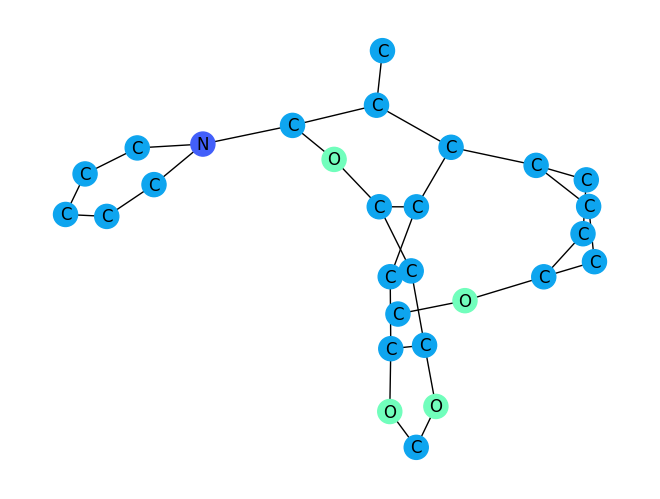

In [ ]:
#displaying one sample
plt.clf()
visualize(training_set[0])

# **Preprocessing**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_vocab = 500
max_len = 100


# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
random.seed(10)

#method to prepare single batch set
#samples represents the batch of data
def prepare_single_batch(samples):
 #nodes characters array
    sample_nodes = [s[0] for s in samples]  
#tokenizing the sample nodes                   
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)   
#pad_sequences for each sample node with post padding
    sample_nodes = pad_sequences(sample_nodes, padding='post')  
#maximum length of nodes 
    max_nodes_len = np.shape(sample_nodes)[1]                   
#defining edges
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)] 
    edges = [e for e in edges if len(e) > 0]
#array definition for segmented_ids
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]  
#reshaping as 1 vector
    all_nodes = np.reshape(sample_nodes, -1)  
#concatenating all the edges as size [total_edges ,2]
    all_edges = np.concatenate(edges)         

    node_to_graph = np.reshape(node_to_graph, -1)
#returns a dictionary of features(data,edges,node2grah) and label
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples]) 

#generating batch with given btch_size
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
 #infinity loop
    while True:                
#data in the array
        dataset = list(dataset) 
# if shuffle is True
        if shuffle:             
#randomly shuffling
            random.shuffle(dataset) 
#length of dataset
        l = len(dataset)  
#loop for  creating batches from given dataset
        for ndx in range(0, l, batch_size):  
#creating batch samples with given batch_size
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] 
#returning a generator with prepared batches
            yield prepare_single_batch(batch_samples)  
#breaking loop if repeat is false 
        if not repeat:  
            break


In [ ]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[ 5  4  2  3  3  3  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  0  0  0  0  0  0  0  4  2  2  2  3  3  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  5  5  2  2  2  3
  3  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1 10  7  2  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
edges
[[  0  22]
 [  1   8]
 [  2  10]
 [  2  11]
 [  3   5]
 [  3   7]
 [  3   8]
 [  4   6]
 [  4   7]
 [  5  13]
 [  6   8]
 [  7   9]
 [  9  16]
 [  9  17]
 [ 10  12]
 [ 10  14]
 [ 11  13]
 [ 11  15]
 [ 12  18]
 [ 12  19]
 [ 14  15]
 [ 16  20]
 [ 17  21]
 [ 18  23]
 [ 19  24]
 [ 20  25]
 [ 21  25]
 [ 22  23]
 [ 22  24]
 [ 33  40]
 [ 33  41]
 [ 34  48]
 [ 35  56]
 [ 35  57]
 [ 36  56]
 [ 37  39]
 [ 37  48]
 [ 38  55]
 [ 38  56]
 [ 39  40]
 [ 39  44]
 [ 39  45]
 [ 40  43]
 [ 41  42]
 [ 41  46]
 [ 42  43]
 [ 42  47]
 [ 44  49]
 [ 45  50]
 [ 46  52]
 [ 47  53]
 [ 48  54]
 [ 49  51]
 [ 

In [ ]:
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
#for deep Graph Neural Network
from tf2_gnn.layers.gnn import GNN, GNNInput

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.0/388.0 kB 37.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.9/173.9 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 5.4 MB/s eta 0:00:00


#**Trial 1**

in this trial i didn't change in the template so the accurracy between 70 and 78 % so  i will change in the hyperparameaters in the next trials and recheck the performance 

##**Model Structure**

In [ ]:
#importing tensorflow and other libraries
import tensorflow as tf
from tensorflow.math import segment_mean #to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model #layers and model
from tensorflow.keras.layers import Embedding, Dense #layers
from tensorflow.keras.optimizers import Adam #optimizer


#Input layer for nodes (tokenized text data) 
data = keras.Input(batch_shape=(None,))             

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data         
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)  
#Input layer for node2graph ids    
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
#embedding layer over data with each token embedded as  size vector 
embeded = Embedding(tokenizer.num_words, 100)(data)  

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))    
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
#sets the size of the output of all message passing layers.
params["hidden_dim"] = 40  

#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
#outpur shape: [data_dimension,hidden layers]   
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    ) #shape: [batch_size,64]  

print('mean:', avg)

#final dense layer with sigmoid
 #output shape: [batch_size,1]
pred = Dense(1, activation='sigmoid')(avg)  
print('pred:', pred)

#building model 
#inputs are data,edges and node2graph
#input: dictionary
#output: prediction value from dense layer
model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#printing summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

##**Compile The Model**

In [ ]:
#compile the model by usnig adam as optimizer and 
#using binarycrossentropy for calculate the loss and check the acc by AUC 
model.compile( optimizer='adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

##**Train The Model**

In [ ]:
import math
batch_size = 8
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
#train our model 
model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
#the number of epochs 
    epochs=26,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/26
2659/2659 [==============================] - 62s 19ms/step - loss: 0.2085 - auc: 0.5638 - val_loss: 0.1923 - val_auc: 0.6317
Epoch 2/26
2659/2659 [==============================] - 35s 13ms/step - loss: 0.1871 - auc: 0.6610 - val_loss: 0.1874 - val_auc: 0.6797
Epoch 3/26
2659/2659 [==============================] - 33s 13ms/step - loss: 0.1836 - auc: 0.6895 - val_loss: 0.1791 - val_auc: 0.7270
Epoch 4/26
2659/2659 [==============================] - 35s 13ms/step - loss: 0.1789 - auc: 0.7155 - val_loss: 0.1787 - val_auc: 0.7272
Epoch 5/26
2659/2659 [==============================] - 36s 14ms/step - loss: 0.1758 - auc: 0.7375 - val_loss: 0.1727 - val_auc: 0.7586
Epoch 6/26
2659/2659 [==============================] - 39s 15ms/step - loss: 0.1741 - auc: 0.7506 - val_loss: 0.1713 - val_auc: 0.7659
Epoch 7/26
2659/2659 [==============================] - 35s 13ms/step - loss: 0.1752 - auc: 0.7428 - val_loss: 0.1689 - val_auc: 0.7650
Epoch 8/26
2659/2659 [==========================

##**Predictoin And Submission**

In [ ]:
#make prediction on test data by using the trained model 
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

771/771 [==============================] - 5s 6ms/step


In [ ]:
len(y_pred)

12326

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('submission 4.csv')

#**Trial 2**

in this trial i change the "message_calculation_class" = 'GGNN' Compute new graph states by neural message passing and gated units on the nodes. but by using unbalanced data so we check the accurracy it is not good so we can check another hyperparameaters 

##**Model Structure**

In [ ]:
#importing tensorflow and other libraries
#GGNN,RGCN,RGAT,RGIN,GNN-Edge-MLP,GNN-FiLM
#import tf2_gnn.layers.message_passing.gnn_edge_mlp
from  tf2_gnn.layers.message_passing import rgat,rgin,rgcn,gnn_film,ggnn,gnn_edge_mlp
import tensorflow as tf
from tensorflow.math import segment_mean #to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model #layers and model
from tensorflow.keras.layers import Embedding, Dense #layers
from tensorflow.keras.optimizers import Adam #optimizer


#Input layer for nodes (tokenized text data)          
data = keras.Input(batch_shape=(None,)) 
# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data        
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)   
#Input layer for node2graph ids    
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
#embedding layer over data with each token embedded as  size vector
embeded = Embedding(tokenizer.num_words, 75)(data)  

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))  
num_graph = tf.reduce_max(node2graph)+1  
#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 32 
params["message_calculation_class"] = 'GGNN'
#params["num_edge_MLP_hidden_layers"] = 16
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
#outpur shape: [data_dimension,hidden layers]  
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )#shape: [batch_size,64] 

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(8,activation='relu')(avg) 
#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc1)   
print('pred:', pred)

#building model 
#inputs are data,edges and node2graph
#input: dictionary
#output: prediction value from dense layer
model_2 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#printing summary of the model
model_2.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []        

##**Compile The Model**

In [ ]:
model_2.compile( loss='BinaryCrossentropy', metrics=['AUC'])

##**Train The Model**

In [ ]:
import math

batch_size = 64

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size) 
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) 

model_2.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/20
333/333 [==============================] - 13s 24ms/step - loss: 0.2249 - auc: 0.5342 - val_loss: 0.2035 - val_auc: 0.6297
Epoch 2/20
333/333 [==============================] - 5s 16ms/step - loss: 0.1873 - auc: 0.6234 - val_loss: 0.2113 - val_auc: 0.6466
Epoch 3/20
333/333 [==============================] - 6s 19ms/step - loss: 0.1866 - auc: 0.6367 - val_loss: 0.1880 - val_auc: 0.6893
Epoch 4/20
333/333 [==============================] - 5s 16ms/step - loss: 0.1857 - auc: 0.6511 - val_loss: 0.1663 - val_auc: 0.6079
Epoch 5/20
333/333 [==============================] - 6s 19ms/step - loss: 0.1850 - auc: 0.6481 - val_loss: 0.2061 - val_auc: 0.6428
Epoch 6/20
333/333 [==============================] - 5s 16ms/step - loss: 0.1845 - auc: 0.6580 - val_loss: 0.2123 - val_auc: 0.6805
Epoch 7/20
333/333 [==============================] - 6s 17ms/step - loss: 0.1849 - auc: 0.6640 - val_loss: 0.1743 - val_auc: 0.6115
Epoch 8/20
333/333 [==============================] - 6s 17ms/step -

##**Predictoin And Submission**

In [ ]:
#make prediction on test data by using the trained model 
y_pred_2 = model_2.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred_2 = np.reshape(y_pred_2, -1)

771/771 [==============================] - 5s 6ms/step


In [ ]:
len(y_pred_2)

12326

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred_2})
submission.index.name = 'id'
submission.to_csv('submission_model_2.csv')

#**Trial 3**

in this trial i added hyperparameters
num_edge_MLP_hidden_layers by 16  and use message_calculation_class" = 'RGCN' and another change in the number of a vector space of 50 dimensions in which words will be embedded and in hidden_dim by 64 when i fit the model the accuracy between 68 and 75 so we can check another hyperparameters and check the accurracy 

##**Model Structure**

In [ ]:
#importing tensorflow and other libraries
#GGNN,RGCN,RGAT,RGIN,GNN-Edge-MLP,GNN-FiLM
#import tf2_gnn.layers.message_passing.gnn_edge_mlp
from  tf2_gnn.layers.message_passing import rgat,rgin,rgcn,gnn_film,ggnn,gnn_edge_mlp
import tensorflow as tf
from tensorflow.math import segment_mean #to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model #layers and model
from tensorflow.keras.layers import Embedding, Dense #layers
from tensorflow.keras.optimizers import Adam #optimizer


#Input layer for nodes (tokenized text data)          
data = keras.Input(batch_shape=(None,)) 
# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data        
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)   
#Input layer for node2graph ids    
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
#embedding layer over data with each token embedded as  size vector
embeded = Embedding(tokenizer.num_words, 50)(data)  

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))  
num_graph = tf.reduce_max(node2graph)+1  
#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 64
#Relational Graph Convolutional Networks  
params["message_calculation_class"] = 'RGCN'
params["num_edge_MLP_hidden_layers"] = 16
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
#outpur shape: [data_dimension,hidden layers]  
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )#shape: [batch_size,64] 

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(8,activation='relu')(avg) 
#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc1)   
print('pred:', pred)

#building model 
#inputs are data,edges and node2graph
#input: dictionary
#output: prediction value from dense layer
model_3 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#printing summary of the model
model_3.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []        

##**Compile The Model**

In [ ]:
model_3.compile( loss='BinaryCrossentropy', metrics=['AUC'])

##**Train The Model**

In [ ]:
import math

batch_size = 32

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size) 
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) 

model_3.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/20
665/665 [==============================] - 32s 28ms/step - loss: 0.3467 - auc: 0.4712 - val_loss: 0.2054 - val_auc: 0.3254
Epoch 2/20
665/665 [==============================] - 17s 25ms/step - loss: 0.1952 - auc: 0.5299 - val_loss: 0.1893 - val_auc: 0.5425
Epoch 3/20
665/665 [==============================] - 15s 22ms/step - loss: 0.1927 - auc: 0.5892 - val_loss: 0.1887 - val_auc: 0.6462
Epoch 4/20
665/665 [==============================] - 15s 22ms/step - loss: 0.1919 - auc: 0.5965 - val_loss: 0.2014 - val_auc: 0.6183
Epoch 5/20
665/665 [==============================] - 16s 23ms/step - loss: 0.1921 - auc: 0.5917 - val_loss: 0.1956 - val_auc: 0.6002
Epoch 6/20
665/665 [==============================] - 16s 23ms/step - loss: 0.1914 - auc: 0.5987 - val_loss: 0.1843 - val_auc: 0.6346
Epoch 7/20
665/665 [==============================] - 16s 24ms/step - loss: 0.1910 - auc: 0.6102 - val_loss: 0.1964 - val_auc: 0.6234
Epoch 8/20
665/665 [==============================] - 15s 23ms

##**Predictoin And Submission**

In [ ]:
#make prediction on test data by using the trained model 
y_pred_3 = model_3.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred_3 = np.reshape(y_pred_3, -1)

771/771 [==============================] - 6s 6ms/step


In [ ]:
len(y_pred_3)

12326

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred_3})
submission.index.name = 'id'
submission.to_csv('submission_model_3.csv')

#**Trial 4**

in this trial i used "message_calculation_class"= "RGAT"  and hidden_dim by 32 and num_heads by 32 and after i check the accurracy  and validation accuracy, the accuracy still between 70 and 80 % so we can check by another hyperparameaters 

##**Model Structure**

In [ ]:
# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 60)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
#"message_calculation_class" configures the message passing style. 
# This chooses the tf2_gnn.layers.message_passing.* layer used in each step.
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32 
#use GGNN as a calculation class 
params["message_calculation_class"]= "RGAT" 
params["num_heads"]=32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)
# create model 
model_4 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_4.summary() 

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []        

##**Compile The Model**

In [ ]:
model_4.compile( loss='BinaryCrossentropy', metrics=['AUC'])

##**Train The Model**

In [ ]:
batch_size = 400
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model_4.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=40,
    validation_data=gen_batch(
        validation_set, batch_size=400, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/40
54/54 [==============================] - 29s 159ms/step - loss: 0.6308 - auc: 0.4722 - val_loss: 0.4685 - val_auc: 0.4056
Epoch 2/40
54/54 [==============================] - 7s 121ms/step - loss: 0.3366 - auc: 0.3966 - val_loss: 0.2847 - val_auc: 0.3592
Epoch 3/40
54/54 [==============================] - 6s 106ms/step - loss: 0.2799 - auc: 0.3675 - val_loss: 0.2780 - val_auc: 0.3501
Epoch 4/40
54/54 [==============================] - 7s 122ms/step - loss: 0.2695 - auc: 0.3509 - val_loss: 0.2415 - val_auc: 0.3714
Epoch 5/40
54/54 [==============================] - 6s 103ms/step - loss: 0.2363 - auc: 0.3807 - val_loss: 0.2361 - val_auc: 0.5516
Epoch 6/40
54/54 [==============================] - 6s 118ms/step - loss: 0.2090 - auc: 0.5148 - val_loss: 0.2250 - val_auc: 0.4825
Epoch 7/40
54/54 [==============================] - 5s 99ms/step - loss: 0.2040 - auc: 0.5414 - val_loss: 0.2065 - val_auc: 0.5326
Epoch 8/40
54/54 [==============================] - 6s 121ms/step - loss: 0.

##**Predictoin And Submission**

In [ ]:
#make prediction on test data by using the trained model 
y_pred_4 = model_4.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred_4 = np.reshape(y_pred_4, -1)

771/771 [==============================] - 15s 17ms/step


In [ ]:
len(y_pred_4)

12326

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred_4})
submission.index.name = 'id'
submission.to_csv('submission_model_4.csv')

#**Trial 5**

in this trial i change in "message_calculation_class"] = 'RGIN' and change in another hyperparameaters after i check the accurracy it between 70 and 80 % so we can check by another hyperparameaters 

##**Model Structure**

In [ ]:
#importing tensorflow and other libraries
#GGNN,RGCN,RGAT,RGIN,GNN-Edge-MLP,GNN-FiLM
#import tf2_gnn.layers.message_passing.gnn_edge_mlp
from  tf2_gnn.layers.message_passing import rgat,rgin,rgcn,gnn_film,ggnn,gnn_edge_mlp
import tensorflow as tf
from tensorflow.math import segment_mean #to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model #layers and model
from tensorflow.keras.layers import Embedding, Dense #layers
from tensorflow.keras.optimizers import Adam #optimizer


#Input layer for nodes (tokenized text data)          
data = keras.Input(batch_shape=(None,)) 
# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data        
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)   
#Input layer for node2graph ids    
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
#embedding layer over data with each token embedded as  size vector
embeded = Embedding(tokenizer.num_words, 150)(data)  

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))  
num_graph = tf.reduce_max(node2graph)+1  
#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 50
#Relational Graph Isomorphism Networks 
params["message_calculation_class"] = 'RGIN'
params["num_edge_MLP_hidden_layers"] = 32 ##
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
#outpur shape: [data_dimension,hidden layers]  
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )#shape: [batch_size,64] 

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(8,activation='relu')(avg) 
#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc1)   
print('pred:', pred)

#building model 
#inputs are data,edges and node2graph
#input: dictionary
#output: prediction value from dense layer
model_5 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#printing summary of the model
model_5.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []        

##**Compile The Model**

In [ ]:
model_5.compile( loss='BinaryCrossentropy', metrics=['AUC'])

##**Train The Model**

In [ ]:
import math

batch_size = 16

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size) 
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) 

model_5.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0", s

333/333 [==============================] - 21s 48ms/step - loss: 0.2035 - auc: 0.5818 - val_loss: 0.1738 - val_auc: 0.6971
Epoch 2/20
333/333 [==============================] - 13s 39ms/step - loss: 0.1853 - auc: 0.6527 - val_loss: 0.2159 - val_auc: 0.6590
Epoch 3/20
333/333 [==============================] - 14s 42ms/step - loss: 0.1826 - auc: 0.6702 - val_loss: 0.1593 - val_auc: 0.7007
Epoch 4/20
333/333 [==============================] - 11s 35ms/step - loss: 0.1820 - auc: 0.6720 - val_loss: 0.1662 - val_auc: 0.7348
Epoch 5/20
333/333 [==============================] - 11s 34ms/step - loss: 0.1789 - auc: 0.6963 - val_loss: 0.1573 - val_auc: 0.6940
Epoch 6/20
333/333 [==============================] - 12s 35ms/step - loss: 0.1769 - auc: 0.7051 - val_loss: 0.2160 - val_auc: 0.7162
Epoch 7/20
333/333 [==============================] - 15s 47ms/step - loss: 0.1746 - auc: 0.7209 - val_loss: 0.2088 - val_auc: 0.7885
Epoch 8/20
333/333 [==============================] - 13s 39ms/step - los

##**Predictoin And Submission**

In [ ]:
#make prediction on test data by using the trained model 
y_pred_5 = model_5.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred_5 = np.reshape(y_pred_5, -1)

In [ ]:
len(y_pred_5)

12326

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred_5})
submission.index.name = 'id'
submission.to_csv('submission_model_5.csv')

#**Solve Unbalanced Data** 

In [ ]:
from sklearn.utils import resample
#read the training data as a dataframe
df = pd.DataFrame(training_set,columns=['Nodes','Edges','Labels']) 
df_majority = df[df['Labels']==0]  #data with majority class
df_minority = df[df['Labels']==1]  #data with maniority class

print('Shape of Unbalanced Data before Upsampling:')
print(df_majority.shape)
print(df_minority .shape)
print('\n')

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                  # sample with replacement 
                                 replace=True, 
                                 # to match majority class                 
                                 n_samples=len(df_majority),
                                  # reproducible results     
                                 random_state=42)               

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
print('New class counts after Upsampling:')
df_upsampled['Labels'].value_counts()

Shape of Unbalanced Data before Upsampling:
(20235, 3)
(20235, 3)


New class counts after Upsampling:


0    20235
1    20235
Name: Labels, dtype: int64

In [ ]:
#convert the dataframe of data to numpy array so we can deal with
training_set= df_upsampled.to_numpy()

#**Trial 6 With Balanced Data**


The GNN layer takes a GNNInput named tuple as input, which encapsulates:

  1) Initial node features

  2) Adjacency lists

  3) Auxiliary information

In this trial we will use   "message_calculation_class": "gnn_edge_mlp" which configures the message passing style

the accuracy improved and became between 80 and 97 % 


##**Model Structure**

In [ ]:
#importing libraries
import tensorflow as tf
from tensorflow.math import segment_mean 
from tensorflow import keras
from tensorflow.keras import Input, Model 
from tensorflow.keras.layers import Embedding, Dense 
from tensorflow.keras.optimizers import Adam 

#identify the 4 GNNInput inputs(data, edge, node2graph, num_graph)
data = keras.Input(batch_shape=(None,))                           #Input layer for nodes (tokenized text data)            
embeded = Embedding(tokenizer.num_words, 100)(data)               #embedding layer over data with each token embedded as  size vector 
# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)         #Input layer for edge data         
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)     #Input layer for node2graph ids    
# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1                           #number of graphs (number of samples) 

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64 
#defining hidden dimension of the gnn layer(the output of all message passing layers)                   
params["message_calculation_class"] = 'gnn_edge_mlp'
params["num_aggr_MLP_hidden_layers"] = 4

#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
gnn_out = gnn_layer(gnn_input) 
print('gnn_out', gnn_out)           

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )                                     
print('mean:', avg)

#final dense layer with sigmoid activation function
pred = Dense(1, activation='sigmoid')(avg)    
print('pred:', pred)

#building model 
# input : dictionary of data,edges and node2graph
# output: prediction value from dense layer

model_6 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#display model summary 
model_6.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_26/StatefulPartitionedCall:0', description="created by layer 'gnn_26'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_7/Sigmoid:0', description="created by layer 'dense_7'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_80 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_78 (InputLayer)          [(None,)]            0           []      

##**Compile The Model**

In [ ]:
model_6.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['AUC'])

##**Train The Model**

In [ ]:
import math

batch_size = 16

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size) 
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) 

model_6.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/20
2530/2530 [==============================] - 39s 14ms/step - loss: 0.6045 - auc: 0.7361 - val_loss: 0.5700 - val_auc: 0.7437
Epoch 2/20
2530/2530 [==============================] - 33s 13ms/step - loss: 0.5660 - auc: 0.7776 - val_loss: 0.5752 - val_auc: 0.7766
Epoch 3/20
2530/2530 [==============================] - 34s 13ms/step - loss: 0.5342 - auc: 0.8076 - val_loss: 0.5342 - val_auc: 0.7901
Epoch 4/20
2530/2530 [==============================] - 32s 13ms/step - loss: 0.5058 - auc: 0.8328 - val_loss: 0.5059 - val_auc: 0.8055
Epoch 5/20
2530/2530 [==============================] - 32s 13ms/step - loss: 0.4721 - auc: 0.8577 - val_loss: 0.5742 - val_auc: 0.8151
Epoch 6/20
2530/2530 [==============================] - 32s 12ms/step - loss: 0.4438 - auc: 0.8753 - val_loss: 0.6598 - val_auc: 0.7988
Epoch 7/20
2530/2530 [==============================] - 33s 13ms/step - loss: 0.4164 - auc: 0.8908 - val_loss: 0.4483 - val_auc: 0.8135
Epoch 8/20
2530/2530 [==========================

##**Predictoin And Submission**

In [ ]:
#make prediction on test data by using the trained model 
y_pred_6 = model_6.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred_6 = np.reshape(y_pred_6, -1)

771/771 [==============================] - 4s 5ms/step


In [ ]:
len(y_pred_6)

12326

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred_6})
submission.index.name = 'id'
submission.to_csv('submission_model_6.csv')

#**Trial 7 With Balanced Data**

in this trial i used "message_calculation_class"] ='GNN_FiLM'
and "film_parameter_MLP_hidden_layers" by 1   the accuracy became between 90 and 98 % so this is the best model 

##**Model Structure**

In [ ]:
#importing libraries
import tensorflow as tf
from tensorflow.math import segment_mean 
from tensorflow import keras
from tensorflow.keras import Input, Model 
from tensorflow.keras.layers import Embedding, Dense 
from tensorflow.keras.optimizers import Adam 

#identify the 4 GNNInput inputs(data, edge, node2graph, num_graph)
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))
#embedding layer over data with each token embedded as  size vector 
#the first dim is different to the previous one. it is the total number of edges in this batch
embeded = Embedding(tokenizer.num_words, 100)(data)              
#Input layer for edge data 
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)         
#Input layer for node2graph ids         
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)        
# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1                           
#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
#defining hidden dimension of the gnn layer(the output of all message passing layers)
params["film_parameter_MLP_hidden_layers"] = 1
params["message_calculation_class"] ='GNN_FiLM'

#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
gnn_out = gnn_layer(gnn_input) 
print('gnn_out', gnn_out)           

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )                                     
print('mean:', avg)

#final dense layer with sigmoid activation function
pred = Dense(1, activation='sigmoid')(avg)    
print('pred:', pred)

#building model 
"""
input : dictionary of data,edges and node2graph
output: prediction value from dense layer
"""
model_7 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#display model summary 
model_7.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_27/StatefulPartitionedCall:0', description="created by layer 'gnn_27'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_6/SegmentMean:0', description="created by layer 'tf.math.segment_mean_6'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_8/Sigmoid:0', description="created by layer 'dense_8'")
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_83 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_81 (InputLayer)          [(None,)]            0           []      

##**Compile The Model**

In [ ]:
model_7.compile(optimizer='adam',loss='BinaryCrossentropy', metrics=['AUC'])

##**Train The Model**

In [ ]:
import math
batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size) 
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) 

model_7.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/20
1265/1265 [==============================] - 30s 19ms/step - loss: 0.5849 - auc: 0.7574 - val_loss: 0.9076 - val_auc: 0.7283
Epoch 2/20
1265/1265 [==============================] - 20s 16ms/step - loss: 0.5091 - auc: 0.8301 - val_loss: 0.6614 - val_auc: 0.8189
Epoch 3/20
1265/1265 [==============================] - 19s 15ms/step - loss: 0.4738 - auc: 0.8559 - val_loss: 0.5664 - val_auc: 0.8218
Epoch 4/20
1265/1265 [==============================] - 20s 16ms/step - loss: 0.4301 - auc: 0.8830 - val_loss: 0.4605 - val_auc: 0.8501
Epoch 5/20
1265/1265 [==============================] - 19s 15ms/step - loss: 0.3964 - auc: 0.9022 - val_loss: 0.4409 - val_auc: 0.8719
Epoch 6/20
1265/1265 [==============================] - 20s 16ms/step - loss: 0.3605 - auc: 0.9199 - val_loss: 0.5130 - val_auc: 0.8096
Epoch 7/20
1265/1265 [==============================] - 19s 15ms/step - loss: 0.3239 - auc: 0.9352 - val_loss: 0.3791 - val_auc: 0.8279
Epoch 8/20
1265/1265 [==========================

##**Predictoin And Submission**

In [ ]:
#make prediction on test data by using the trained model 
y_pred_7 = model_7.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred_7 = np.reshape(y_pred_7, -1)

771/771 [==============================] - 4s 5ms/step


In [ ]:
len(y_pred_7)

12326

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred_7})
submission.index.name = 'id'
submission.to_csv('submission_model_7.csv')

#**Trial 8 With Balanced Data**

in this trial i used last "message_calculation_class"] ='GNN_FiLM' but different hyperparameaters and after i check the accurracy it began by 82 and increase until 95 and decrease again to 75 % 

##**Model Structure**

In [ ]:
#importing libraries
import tensorflow as tf
from tensorflow.math import segment_mean 
from tensorflow import keras
from tensorflow.keras import Input, Model 
from tensorflow.keras.layers import Embedding, Dense 
from tensorflow.keras.optimizers import Adam 


#identify the 4 GNNInput inputs(data, edge, node2graph, num_graph)
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))  
#embedding layer over data with each token embedded as  size vector                                      
embeded = Embedding(tokenizer.num_words, 100)(data)               
# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data 
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)         
#Input layer for node2graph ids        
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)         
# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1                           

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer(the output of all message passing layers)
params["hidden_dim"] = 40
params["film_parameter_MLP_hidden_layers"] = 1
params["message_calculation_class"] ='GNN_FiLM'

#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
gnn_out = gnn_layer(gnn_input) 
print('gnn_out', gnn_out)           

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )                                     
print('mean:', avg)

#final dense layer with sigmoid activation function
pred = Dense(1, activation='sigmoid')(avg)    
print('pred:', pred)

#building model 
# input : dictionary of data,edges and node2graph
# output: prediction value from dense layer

model_8 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#display model summary 
model_8.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_28/StatefulPartitionedCall:0', description="created by layer 'gnn_28'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_7/SegmentMean:0', description="created by layer 'tf.math.segment_mean_7'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_9/Sigmoid:0', description="created by layer 'dense_9'")
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_86 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_84 (InputLayer)          [(None,)]            0           []      

##**Compile The Model**

In [ ]:
model_8.compile(
    optimizer=keras.optimizers.Adam(),
    loss='BinaryCrossentropy',
    metrics=['AUC'])

##**Train The Model**

In [ ]:
import math

batch_size = 32

#math.ceil: returns the smallest integral value greater than the number
num_batchs            = math.ceil(len(training_set) / batch_size)   #no. of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) #no. of batches for validation data

model_8.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    validation_data=gen_batch(validation_set, batch_size=batch_size, repeat=True),
    validation_steps=num_batchs_validation,
     epochs=35,
)

Epoch 1/35
1265/1265 [==============================] - 29s 18ms/step - loss: 0.5859 - auc: 0.7560 - val_loss: 0.5835 - val_auc: 0.8127
Epoch 2/35
1265/1265 [==============================] - 19s 15ms/step - loss: 0.4958 - auc: 0.8402 - val_loss: 0.6525 - val_auc: 0.8306
Epoch 3/35
1265/1265 [==============================] - 19s 15ms/step - loss: 0.4490 - auc: 0.8725 - val_loss: 0.5610 - val_auc: 0.8362
Epoch 4/35
1265/1265 [==============================] - 19s 15ms/step - loss: 0.4109 - auc: 0.8946 - val_loss: 0.5160 - val_auc: 0.8523
Epoch 5/35
1265/1265 [==============================] - 18s 15ms/step - loss: 0.3887 - auc: 0.9066 - val_loss: 0.5438 - val_auc: 0.8497
Epoch 6/35
1265/1265 [==============================] - 21s 17ms/step - loss: 0.3552 - auc: 0.9224 - val_loss: 0.5065 - val_auc: 0.8483
Epoch 7/35
1265/1265 [==============================] - 19s 15ms/step - loss: 0.3335 - auc: 0.9311 - val_loss: 0.4380 - val_auc: 0.8593
Epoch 8/35
1265/1265 [==========================

##**Predictoin And Submission**

In [ ]:
#make prediction on test data by using the trained model 
y_pred_8 = model_8.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred_8 = np.reshape(y_pred_8, -1)

771/771 [==============================] - 5s 5ms/step


In [ ]:
len(y_pred_8)

12326

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred_8})
submission.index.name = 'id'
submission.to_csv('submission_model_8.csv')

#**Trial 9 With Balanced Data** 

in this trial i used as the second trial but after balance the data so the accurracy became between 80 and 95 % but not stables 

##**Model Structure**

In [ ]:
#importing tensorflow and other libraries
#GGNN,RGCN,RGAT,RGIN,GNN-Edge-MLP,GNN-FiLM
#import tf2_gnn.layers.message_passing.gnn_edge_mlp
from  tf2_gnn.layers.message_passing import rgat,rgin,rgcn,gnn_film,ggnn,gnn_edge_mlp
import tensorflow as tf
from tensorflow.math import segment_mean #to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model #layers and model
from tensorflow.keras.layers import Embedding, Dense #layers
from tensorflow.keras.optimizers import Adam #optimizer


#Input layer for nodes (tokenized text data)          
data = keras.Input(batch_shape=(None,)) 
# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data        
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)   
#Input layer for node2graph ids    
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
#embedding layer over data with each token embedded as  size vector
embeded = Embedding(tokenizer.num_words, 75)(data)  

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))  
num_graph = tf.reduce_max(node2graph)+1  
#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 32 
params["message_calculation_class"] = 'GGNN'
#params["num_edge_MLP_hidden_layers"] = 16
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
#outpur shape: [data_dimension,hidden layers]  
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )#shape: [batch_size,64] 

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(8,activation='relu')(avg) 
#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc1)   
print('pred:', pred)

#building model 
#inputs are data,edges and node2graph
#input: dictionary
#output: prediction value from dense layer
model_9 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#printing summary of the model
model_9.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_29/StatefulPartitionedCall:0', description="created by layer 'gnn_29'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_8/SegmentMean:0', description="created by layer 'tf.math.segment_mean_8'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_11/Sigmoid:0', description="created by layer 'dense_11'")
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_89 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_87 (InputLayer)          [(None,)]            0           []    

##**Compile The Model**

In [ ]:
model_9.compile(optimizer='adam',loss='BinaryCrossentropy', metrics=['AUC'])

##**Train The Model**

In [ ]:
import math

batch_size = 64

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size) 
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) 

model_9.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/20
633/633 [==============================] - 22s 23ms/step - loss: 0.6338 - auc: 0.6892 - val_loss: 0.8585 - val_auc: 0.7604
Epoch 2/20
633/633 [==============================] - 11s 18ms/step - loss: 0.5916 - auc: 0.7455 - val_loss: 0.7306 - val_auc: 0.7319
Epoch 3/20
633/633 [==============================] - 11s 18ms/step - loss: 0.5604 - auc: 0.7834 - val_loss: 0.6783 - val_auc: 0.7569
Epoch 4/20
633/633 [==============================] - 11s 18ms/step - loss: 0.5370 - auc: 0.8059 - val_loss: 0.7495 - val_auc: 0.8184
Epoch 5/20
633/633 [==============================] - 11s 18ms/step - loss: 0.5195 - auc: 0.8206 - val_loss: 0.8961 - val_auc: 0.8068
Epoch 6/20
633/633 [==============================] - 11s 17ms/step - loss: 0.4999 - auc: 0.8366 - val_loss: 0.6069 - val_auc: 0.7934
Epoch 7/20
633/633 [==============================] - 10s 16ms/step - loss: 0.4818 - auc: 0.8499 - val_loss: 0.5890 - val_auc: 0.8024
Epoch 8/20
633/633 [==============================] - 11s 17ms

##**Predictoin And Submission**

In [ ]:
#make prediction on test data by using the trained model 
y_pred_9 = model_2.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred_9 = np.reshape(y_pred_9, -1)

771/771 [==============================] - 4s 6ms/step


In [ ]:
len(y_pred_9)

12326

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred_9})
submission.index.name = 'id'
submission.to_csv('submission_model_9.csv')

#**Trial 10 With Balanced Data**

in this trial i used "message_calculation_class"] = 'RGCN' as the same in the third trial with the balanced data so the accurracy became 80 and 95 and if i increase in the number of epochs the performance of the model will increase 

##**Model Structure**

In [ ]:
#importing tensorflow and other libraries
#GGNN,RGCN,RGAT,RGIN,GNN-Edge-MLP,GNN-FiLM
#import tf2_gnn.layers.message_passing.gnn_edge_mlp
from  tf2_gnn.layers.message_passing import rgat,rgin,rgcn,gnn_film,ggnn,gnn_edge_mlp
import tensorflow as tf
from tensorflow.math import segment_mean #to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model #layers and model
from tensorflow.keras.layers import Embedding, Dense #layers
from tensorflow.keras.optimizers import Adam #optimizer


#Input layer for nodes (tokenized text data)          
data = keras.Input(batch_shape=(None,)) 
# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data        
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)   
#Input layer for node2graph ids    
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) 
#embedding layer over data with each token embedded as  size vector
embeded = Embedding(tokenizer.num_words, 50)(data)  

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))  
num_graph = tf.reduce_max(node2graph)+1  
#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 64
#Relational Graph Convolutional Networks  
params["message_calculation_class"] = 'RGCN'
# params["num_edge_MLP_hidden_layers"] = 32
#gnn layer with defined hyperparameters
gnn_layer = GNN(params)  

#gnn output layer 
#outpur shape: [data_dimension,hidden layers]  
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )#shape: [batch_size,64] 

print('mean:', avg)

#final dense layer with sigmoid
#Output [None,8]
fc1 = Dense(8,activation='LeakyReLU')(avg) 
#output shape: [batch_size,1] 
pred = Dense(1, activation='sigmoid')(fc1)   
print('pred:', pred)

#building model 
#inputs are data,edges and node2graph
#input: dictionary
#output: prediction value from dense layer
model_10 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

#printing summary of the model
model_10.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_30/StatefulPartitionedCall:0', description="created by layer 'gnn_30'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_9/SegmentMean:0', description="created by layer 'tf.math.segment_mean_9'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_13/Sigmoid:0', description="created by layer 'dense_13'")
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_92 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_90 (InputLayer)          [(None,)]            0           []    

##**Compile The Model**

In [ ]:
model_10.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['AUC'])

##**Train The Model**

In [ ]:
import math

batch_size = 32

#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size) 
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) 

model_10.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/20
1265/1265 [==============================] - 26s 17ms/step - loss: 0.6207 - auc: 0.7147 - val_loss: 0.8158 - val_auc: 0.7290
Epoch 2/20
1265/1265 [==============================] - 17s 13ms/step - loss: 0.5863 - auc: 0.7548 - val_loss: 0.6270 - val_auc: 0.7833
Epoch 3/20
1265/1265 [==============================] - 18s 15ms/step - loss: 0.5723 - auc: 0.7721 - val_loss: 0.6966 - val_auc: 0.7798
Epoch 4/20
1265/1265 [==============================] - 16s 13ms/step - loss: 0.5539 - auc: 0.7906 - val_loss: 0.6867 - val_auc: 0.7914
Epoch 5/20
1265/1265 [==============================] - 17s 14ms/step - loss: 0.5325 - auc: 0.8106 - val_loss: 0.4968 - val_auc: 0.8213
Epoch 6/20
1265/1265 [==============================] - 17s 13ms/step - loss: 0.5090 - auc: 0.8300 - val_loss: 0.7536 - val_auc: 0.8032
Epoch 7/20
1265/1265 [==============================] - 17s 14ms/step - loss: 0.4861 - auc: 0.8466 - val_loss: 0.5048 - val_auc: 0.8111
Epoch 8/20
1265/1265 [==========================

##**Predictoin And Submission**

In [ ]:
#make prediction on test data by using the trained model 
y_pred_10 = model_10.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred_10 = np.reshape(y_pred_10, -1)

In [ ]:
len(y_pred_10)

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred_10})
submission.index.name = 'id'
submission.to_csv('submission_model_10.csv')